In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import gymnasium as gym
import gym_trading_env

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from RLTrade.agent import DQNAgent, XGBoostAgent
from RLTrade.utils import (
    nonstationary_dgp, 
    FeatureEngineering
)

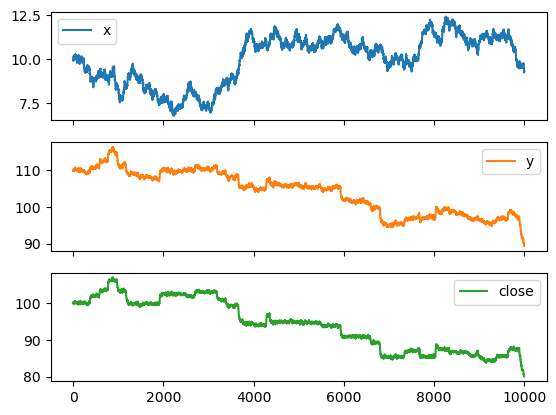

In [2]:
x, y = nonstationary_dgp()
spread = y - x
df = pd.DataFrame({'x': x, 'y': y, 'close': spread}) # close price of portfolio is the spread
df.plot(subplots=True)
plt.show()

In [3]:
# confirm the x, y pair is not cointegrated
x_ols = sm.add_constant(x)
ols = sm.OLS(y, x_ols).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     6483.
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:14:09   Log-Likelihood:                -29161.
No. Observations:               10000   AIC:                         5.833e+04
Df Residuals:                    9998   BIC:                         5.834e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        129.9080      0.325    400.180      0.0

In [4]:
adfuller_test = adfuller(spread)
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: 0.18341670452006203
p-value: 0.971315998397616
Is the spread stationary? No


In [5]:
# build features
df_train = df.copy()

feature_config = [
    {'type': 'rolling',
     'params': {
       'cols': ['close'],
       'window': 7,
       'mode': 'diff',
       'subtract_mean': True
     }},
]

df_train = df.copy()
fe = FeatureEngineering(df_train)
df_train = fe.build_features(feature_config)
df_train

,x,y,close,feature_close_lag_0,feature_close_lag_1,feature_close_lag_2,feature_close_lag_3,feature_close_lag_4,feature_close_lag_5,feature_close_lag_6
0,9.932782,109.948740,100.015959,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,10.012545,110.031871,100.019325,0.001683,-0.001683,0.000000,0.000000,0.000000,0.000000,0.000000
2,10.035881,110.186174,100.150293,0.086190,-0.041412,-0.044778,0.000000,0.000000,0.000000,0.000000
3,9.908213,109.681504,99.773292,-0.316335,0.191635,0.064033,0.060667,0.000000,0.000000,0.000000
4,9.937501,109.822732,99.885231,0.138085,-0.350856,0.157114,0.029512,0.026146,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
9995,9.392044,89.891281,80.499237,0.032167,0.012681,-0.013351,0.063561,0.058163,-0.037418,-0.115803
9996,9.318717,89.667857,80.349140,-0.139225,0.036071,0.016585,-0.009447,0.067464,0.062067,-0.033514
9997,9.230792,89.383548,80.152756,-0.163798,-0.117511,0.057785,0.038299,0.012266,0.089178,0.083781
9998,9.327069,89.476388,80.149319,0.036953,-0.155994,-0.109706,0.065589,0.046103,0.020071,0.096983


In [6]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0) # always short position

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0.]
Market Return : -19.92%   |   Portfolio Return : 19.91%   |   Position Changes : 1   |   Episode Length : 10000   |   


In [7]:
# Train a DQN agent using training data from a stationary data generating process
agent = DQNAgent(n_observations=n_observations, n_actions=n_actions)
history_metrics, _ = agent.train(env, num_episodes=15) # Beware of overfitting when num_episodes is too high

Market Return : -19.92%   |   Portfolio Return : -55.10%   |   Position Changes : 6467   |   Episode Length : 10000   |   
Market Return : -19.92%   |   Portfolio Return : -30.45%   |   Position Changes : 3982   |   Episode Length : 10000   |   
Market Return : -19.92%   |   Portfolio Return : -23.37%   |   Position Changes : 3538   |   Episode Length : 10000   |   
Market Return : -19.92%   |   Portfolio Return : -26.03%   |   Position Changes : 3333   |   Episode Length : 10000   |   
Market Return : -19.92%   |   Portfolio Return : -18.10%   |   Position Changes : 3123   |   Episode Length : 10000   |   
Market Return : -19.92%   |   Portfolio Return : -15.15%   |   Position Changes : 2917   |   Episode Length : 10000   |   
Market Return : -19.92%   |   Portfolio Return : -16.05%   |   Position Changes : 3062   |   Episode Length : 10000   |   
Market Return : -19.92%   |   Portfolio Return : -9.81%   |   Position Changes : 2942   |   Episode Length : 10000   |   
Market Return : -

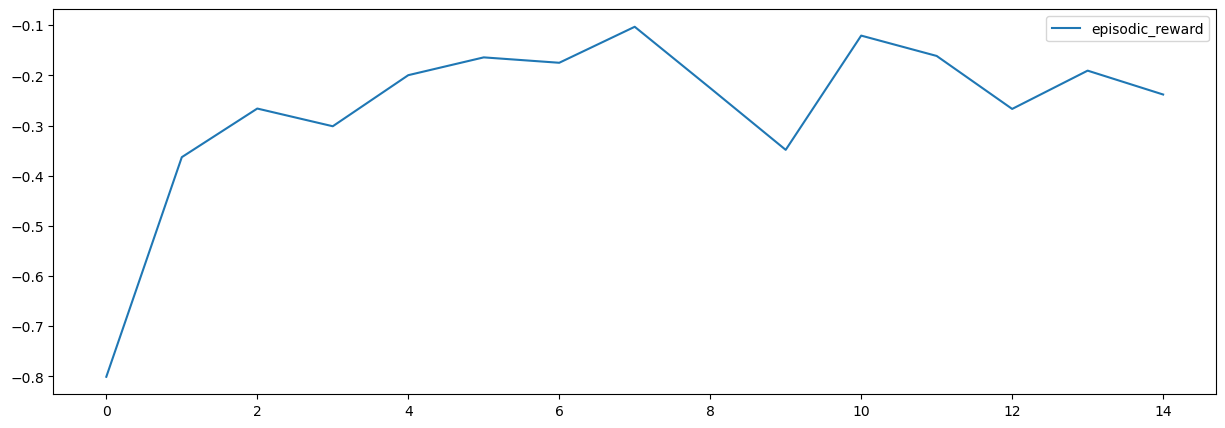

In [8]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [9]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x, y = nonstationary_dgp()
    spread = y - x
    _df = pd.DataFrame({'x': x, 'y': y, 'close': spread})
    fe = FeatureEngineering(_df)
    _df = fe.build_features(feature_config)
    
    env_test = gym.make("TradingEnv",
            name= "stationaryDGP",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return : 24.36%   |   Portfolio Return : -34.31%   |   Position Changes : 2096   |   Episode Length : 10000   |   
Market Return : -6.23%   |   Portfolio Return : -3.12%   |   Position Changes : 429   |   Episode Length : 10000   |   
Market Return :  3.99%   |   Portfolio Return : -15.43%   |   Position Changes : 894   |   Episode Length : 10000   |   
Market Return : 10.99%   |   Portfolio Return : -30.95%   |   Position Changes : 2239   |   Episode Length : 10000   |   
Market Return : 16.35%   |   Portfolio Return : -25.58%   |   Position Changes : 1211   |   Episode Length : 10000   |   
Market Return : -3.32%   |   Portfolio Return :  3.58%   |   Position Changes : 6   |   Episode Length : 10000   |   
Market Return : -8.65%   |   Portfolio Return : -0.05%   |   Position Changes : 472   |   Episode Length : 10000   |   
Market Return :  2.49%   |   Portfolio Return : -6.70%   |   Position Changes : 570   |   Episode Length : 10000   |   
Market Return : -33.01%   |   Portf

In [16]:
# build features
df_train = df.copy()

feature_config = [
    {'type': 'rolling_mean_corrected',
     'params': {
       'cols': ['close'],
       'window': 100,
       'mode': 'diff',
     }},
]

fe = FeatureEngineering(df_train)
df_train = fe.build_features(feature_config)
df_train

,x,y,close,feature_close_rolling_mean_corrected
0,9.932782,109.948740,100.015959,0.000000
1,10.012545,110.031871,100.019325,0.001683
2,10.035881,110.186174,100.150293,0.086190
3,9.908213,109.681504,99.773292,-0.316335
4,9.937501,109.822732,99.885231,0.138085
...,...,...,...,...
9995,9.392044,89.891281,80.499237,0.084882
9996,9.318717,89.667857,80.349140,-0.089415
9997,9.230792,89.383548,80.152756,-0.136916
9998,9.327069,89.476388,80.149319,0.056383


In [17]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0) # always short position

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[0. 0. 0.]
Market Return : -19.92%   |   Portfolio Return : 19.91%   |   Position Changes : 1   |   Episode Length : 10000   |   


In [18]:
agent = XGBoostAgent(n_observations, n_actions)
history_metrics, _ = agent.train(env, num_episodes=20, replay_every=2)

Market Return : -19.92%   |   Portfolio Return : -59.74%   |   Position Changes : 6660   |   Episode Length : 10000   |   
Market Return : -19.92%   |   Portfolio Return : -67.17%   |   Position Changes : 6634   |   Episode Length : 10000   |   
Market Return : -19.92%   |   Portfolio Return : -44.67%   |   Position Changes : 5102   |   Episode Length : 10000   |   
Market Return : -19.92%   |   Portfolio Return : -49.80%   |   Position Changes : 4992   |   Episode Length : 10000   |   
Market Return : -19.92%   |   Portfolio Return : -21.25%   |   Position Changes : 3582   |   Episode Length : 10000   |   
Market Return : -19.92%   |   Portfolio Return : -32.66%   |   Position Changes : 3672   |   Episode Length : 10000   |   
Market Return : -19.92%   |   Portfolio Return : -5.00%   |   Position Changes : 2338   |   Episode Length : 10000   |   
Market Return : -19.92%   |   Portfolio Return : -10.65%   |   Position Changes : 2278   |   Episode Length : 10000   |   
Market Return : -

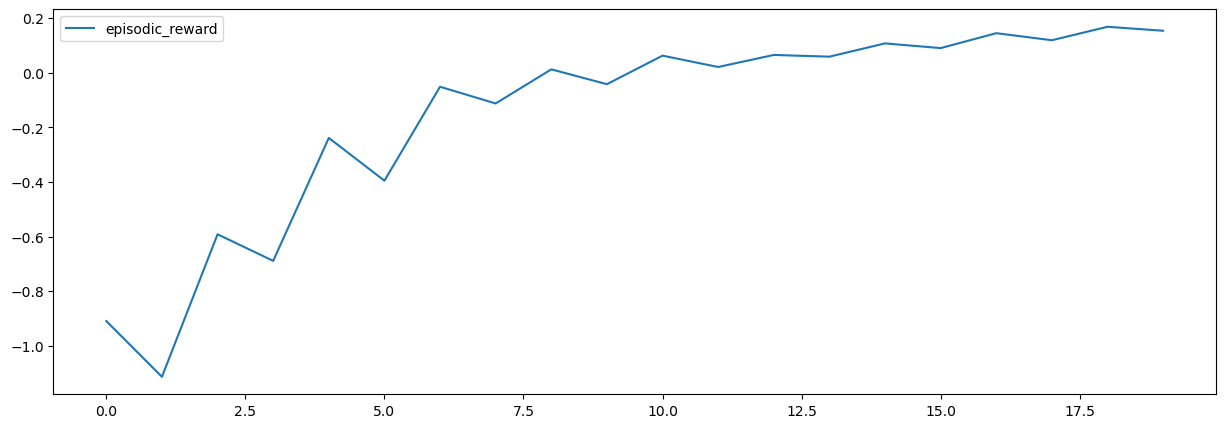

In [19]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

all_metrics.plot(y=["episodic_reward"], figsize=(15, 5))
plt.show()

In [20]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
for i in range(10):
    x, y = nonstationary_dgp()
    spread = y - x
    _df = pd.DataFrame({'x': x, 'y': y, 'close': spread})
    fe = FeatureEngineering(_df)
    _df = fe.build_features(feature_config)
    
    env_test = gym.make("TradingEnv",
            name= "stationaryDGP",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return : -12.49%   |   Portfolio Return :  7.50%   |   Position Changes : 1403   |   Episode Length : 10000   |   
Market Return : -9.95%   |   Portfolio Return : -10.62%   |   Position Changes : 1444   |   Episode Length : 10000   |   
Market Return : -0.30%   |   Portfolio Return : -8.14%   |   Position Changes : 1405   |   Episode Length : 10000   |   
Market Return :  5.90%   |   Portfolio Return : -6.89%   |   Position Changes : 1387   |   Episode Length : 10000   |   
Market Return : -4.38%   |   Portfolio Return : -5.77%   |   Position Changes : 1378   |   Episode Length : 10000   |   
Market Return : -24.00%   |   Portfolio Return : -4.86%   |   Position Changes : 1442   |   Episode Length : 10000   |   
Market Return : -1.27%   |   Portfolio Return :  3.04%   |   Position Changes : 1382   |   Episode Length : 10000   |   
Market Return : -4.96%   |   Portfolio Return : -11.55%   |   Position Changes : 1425   |   Episode Length : 10000   |   
Market Return :  9.72%   |  